# Compute Topic Graphs

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%capture
%pip install bertopic
%pip install sklearn
%pip install sentance_transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from bertopic import BERTopic
import os

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from generate_graphs import construct_graph
import config
import re

import spacy
from sklearn.feature_extraction.text import CountVectorizer

## Data Preprocessing / Cleaning

In [ ]:
sample_size = 300000
random_state = 2

In [ ]:
with open('drive/MyDrive/AAA/_all.csv', 'r+', encoding="utf-8") as file:
  data = [a.split(',') for a in file]

In [ ]:
# Check and clean malformed lines
count_in = 0
count_t = 0
clean_data = []
for a in data:
  count_t += 1
  if len(a) != 5:
    count_in += 1
  else:
      clean_data.append(a)

print(f'in {count_in} + t {count_t} = {count_in / count_t}')

in 0 + t 349400 = 0.0


In [ ]:
df = pd.DataFrame(clean_data)
df = df.set_axis(df.iloc[0], axis=1).drop(df.index[0])

In [ ]:
# Remove URL's from messages so topic detection doesn't turn them into topics
remove_url = lambda string : re.sub(r'http\S+', '', string)
df['MessageText'] = df['MessageText'].apply(remove_url)

In [ ]:
# Construct random sample of messages
sample_df = df.sample(
    n=sample_size, 
    frac=None, 
    replace=False, 
    weights=None, 
    random_state=random_state, 
    axis=None, 
    ignore_index=False
)
sample_texts = list(sample_df['MessageText'])

# Fit Bertopic Model on Subset of Data and Compute Topics

In [ ]:
# Fit topic model on subset of topics
topic_model = BERTopic(embedding_model=SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2"), language = 'multilingual', n_gram_range=(1, 2), min_topic_size=200, nr_topics="auto", verbose = True, low_memory = True, )
topics, probs = topic_model.fit_transform(sample_texts)

In [ ]:
# Save Fit/Fine-tuned version of model
# topic_model.save('topic_model_300K_multil_miniLM_L12_v2')
topic_model.save('drive/MyDrive/LinkedInTheDark/topic_model_300K_multil_miniLM_L12_v2')

/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# Load fit version of the topic model
topic_model = BERTopic.load('drive/MyDrive/LinkedInTheDark/topic_model_300K_multil_miniLM_L12_v2')

IndexError: ignored

In [ ]:
# Train topic model on entire corpus of messages
topics, probs = topic_model.transform(list(df['MessageText']))

Batches:   0%|          | 0/10919 [00:00<?, ?it/s]

2023-04-17 14:10:30,697 - BERTopic - Reduced dimensionality
2023-04-17 14:13:02,435 - BERTopic - Predicted clusters


In [ ]:
# Save list of topics
# with open('topics_with_stopwords.pkl', 'wb') as f:
#    pickle.dump(topics, f)

In [ ]:
# Workaround for bug in current version of colab
#import locale
#def getpreferredencoding(do_setlocale = True):
#   return "UTF-8"
#locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Remove stop words from topics

# The two languages most represented in our corpus are English and Russian
en = spacy.load('en_core_web_sm')
sw_en = en.Defaults.stop_words
stopwords = sw_en


# Update topic representation by increasing n-gram range and removing english stopwords

vectorizer_model = CountVectorizer(ngram_range=(1, 2),stop_words = 'english', min_df = 10)

topic_model.update_topics(df['MessageText'], topics, vectorizer_model=vectorizer_model)

In [ ]:
# Save cleaned / updated topics and topic model

#with open('drive/MyDrive/AAA/topics_cleaned.pkl', 'wb') as f:
#    pickle.dump(topics, f)
#  
with open('drive/MyDrive/LinkedInTheDark/cleaned_topic_model_300K_multil_miniLM_L12_v2', 'wb') as f:
  pickle.dump(topic_model, f)

In [ ]:
#info_df = topic_model.get_topic_info()
all_topics = topic_model.get_topics()
all_topics

In [ ]:
#topic_model.visualize_hierarchy()
topic_model.visualize_heatmap()
#topic_model.visualize_term_rank()
#topic_model.visualize_term_rank(log_scale=True

Note: More infrequent generic topics have "more similar"

In [ ]:
#Interactive map of intertopic distance
intertopic_distance = topic_model.visualize_topics(width=700, height=700)
#save fig
intertopic_distance.write_html('intertopic.html')
#display fig
intertopic_distance

## Compute Topic Frequencies Per Chat/Channel

In [ ]:
docs = df['MessageText']
target_names = list(set(df['FileOrigin\n']))
classes = df['FileOrigin\n']

cat_map = {cat: i for i, cat in enumerate(df['FileOrigin\n'].unique())}
targets = df['FileOrigin\n'].map(cat_map)

In [ ]:
topics_per_class = topic_model.topics_per_class(docs, classes=classes)

56it [00:11,  5.07it/s]


In [ ]:
with open('topics_per_class.pkl', 'wb') as f:
    pickle.dump(topics_per_class, f)
  
with open('drive/MyDrive/LinkedInTheDark/topics_per_class.pkl', 'wb') as f:
    pickle.dump(topics_per_class, f)

In [ ]:
topics_per_class

,Topic,Words,Frequency,Class
0,-1,"red pill, pill, vids, red, deleted",20,./Data/Messages/RawData/chat_@RDBAthiests_epoc...
1,0,"lol, thanks, hi, hello, yeah",30,./Data/Messages/RawData/chat_@RDBAthiests_epoc...
2,1,"insanity, god, thing, tough, figure",3,./Data/Messages/RawData/chat_@RDBAthiests_epoc...
3,5,"ancestors, country, white, built, death",1,./Data/Messages/RawData/chat_@RDBAthiests_epoc...
4,12,"superior, traditions, british, values, appreciate",1,./Data/Messages/RawData/chat_@RDBAthiests_epoc...
...,...,...,...,...
3403,111,"doom, old man, death, sweet, edge",5,./Data/Messages/RawData/chat_@V_of_Europe_epoc...
3404,112,"classes, swiss, switzerland, minority, brown",2,./Data/Messages/RawData/chat_@V_of_Europe_epoc...
3405,113,"ireland, irish, responsibility, bomb, failed",17,./Data/Messages/RawData/chat_@V_of_Europe_epoc...
3406,116,"christmas, attacks, concrete, trees, series",15,./Data/Messages/RawData/chat_@V_of_Europe_epoc...


## Calculate Topic Distances, Topic Frequencies per 

In [ ]:
#with open('drive/MyDrive/AAA/sw_topic_model_300k_multil_miniLM_v2.pkl', 'rb') as f:
#  topic_model = pickle.load(f)

#with open('drive/MyDrive/AAA/topics_per_class.pkl', 'rb') as f:
#  topics_per_class = pickle.load(f)

In [ ]:
# Get distance matrix of cosine similarity distances between topics
distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_)[1:, :])
labels = ["_".join(label.split("_")[1:]) for label in topic_model.get_topic_info().Name[1:]]

In [ ]:
# Load list of chats 
with open('drive/MyDrive/AAA/ActiveChats2023-04-03-cleaned.csv' , "r") as file:
    # Discard cname
    file.readline()
    ch_names = [name.rstrip() for name in file]

# Number of chats
p = len(ch_names)
# Number of topics
n = len(topic_model.get_topics()) - 1 # Topic -1:outliers is not a real topic

In [ ]:
# Compute the matrix of chat-topic TF-RDF frequencies
# pxn where p = |chats|, n = |topics| and frequencies_ij = TFRDF of topic j in chat i

frequencies = {'Epoch 1':np.zeros((p, n)),
               'Epoch 2':np.zeros((p, n)),
               'Epoch 3':np.zeros((p, n)),}

for epoch in frequencies.keys():
  chat_no = 0
  for chat in ch_names:
    # Get all topics from topics matrix
    topic_absolute_frequencies = topics_per_class[topics_per_class['Class'] == f'./Data/Messages/RawData/chat_{chat}_epoch_{epoch}.csv\n']
    # print(topic_absolute_frequencies) is DF with Words Frequency and Topic columns

    # Compute total occurances of all topics in a chat / epoch pair
    total_sum_freq = sum(topic_absolute_frequencies['Frequency'])
    # Compute TF IDF for each topic
    for i in range(n):
      # If topic not present at all TD IDF = 0
      if i not in list(topic_absolute_frequencies['Topic']):
        TFIDF = 0
      else:
        # No in doccument / total of all in doccument
        TF = list(topic_absolute_frequencies[topic_absolute_frequencies['Topic'] == i]['Frequency'])[0] / total_sum_freq
        # IFD = log( total number of doccuments / doccuments that contain the term)
        IDF = np.log(len(ch_names) / topics_per_class['Topic'].value_counts()[i])
        TFIDF = TF * IDF
      frequencies[epoch][chat_no][i] = TFIDF
    chat_no += 1

In [ ]:
frequencies['Epoch 1'].shape
# Compute interchat distances as sandwitch product of topic frequencies and topic distances

adj_mat = {
    'Epoch 1':np.zeros(shape=(len(ch_names), len(ch_names))),
    'Epoch 2':np.zeros(shape=(len(ch_names), len(ch_names))),
    'Epoch 3':np.zeros(shape=(len(ch_names), len(ch_names)))

}
# GraphML from adj mat
for epoch in frequencies.keys():
  adj_mat[epoch] = frequencies[epoch] @ distance_matrix @ frequencies[epoch].T
  construct_graph(
    adj_mat[epoch], # Adjacency matrix with doubble type weights witch will be saved under weight attribute of connection
    ch_names, # Array of names of channels (!in orginal order!)
    epoch, # Name of the epoch
    config.epochs, # Dict specifying epoch config
    config.sample_delta, # Interval of each sample
    config.no_samples, # number of equally spaced samples to use
    'Topic', # Type of graph, should be one of URL, UserID or Topic
    '' # Directory where to store graph data
    )


In [ ]:
# Save distances in dictionary form for conveniance
with open( 'drive/MyDrive/LinkedInTheDark/chat_distances.pkl','wb') as f:
  pickle.dump(adj_mat, f)

In [ ]:
topic_model = BERTopic.load('drive/MyDrive/LinkedInTheDark/cleaned_topic_model_300K_multil_miniLM_L12_v2')

In [ ]:
topic_model.get_topics()

NameError: ignored

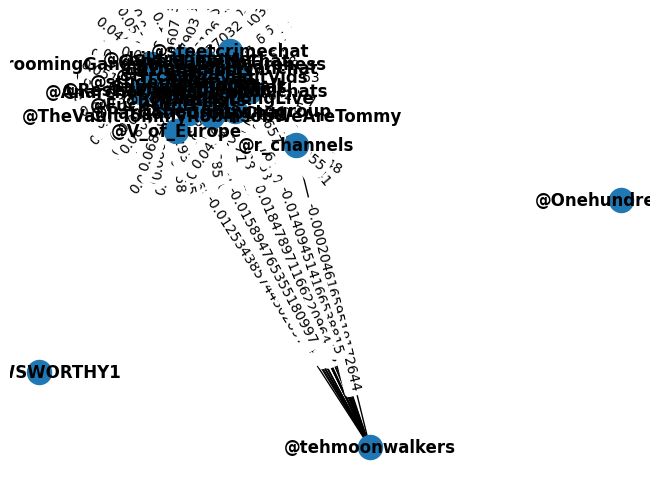

In [ ]:
# Plot saved graphs
from generate_graphs import plot_graphml

plot_graphml('Topic_graph_Epoch 3.graphml')

# Topic Analysis

In [ ]:
with open('drive/MyDrive/AAA/ActiveChats2023-04-03-cleaned.csv' , "r") as file:
    # Discard cname
    file.readline()
    ch_names = [name.rstrip() for name in file]
    ch_names = list(set(ch_names))

In [ ]:
with open('drive/MyDrive/LinkedInTheDark/topics_per_class.pkl', 'rb') as f:
    topics_per_class = pickle.load(f)
  
topics_per_class

,Topic,Words,Frequency,Class
0,-1,"resistance, britain, uk, group https, joinchat",1158,./Data/Messages/RawData/chat_@PatrioticGroupCh...
1,0,"https __, pdf, org web, archive org, pdf https",473,./Data/Messages/RawData/chat_@PatrioticGroupCh...
2,1,"licence, scumbag, young girl, follow ashleasim...",13,./Data/Messages/RawData/chat_@PatrioticGroupCh...
3,2,"white, follow ashleasimonnews, ashleasimonnews...",28,./Data/Messages/RawData/chat_@PatrioticGroupCh...
4,3,"african, immigrants, israel, send, europe",2,./Data/Messages/RawData/chat_@PatrioticGroupCh...
...,...,...,...,...
4288,66,"download, video, mp4, ex, files",1,./Data/Messages/RawData/chat_@Onehundredfags_e...
4289,82,"son, fo, praises, transition, http archive",1,./Data/Messages/RawData/chat_@Onehundredfags_e...
4290,88,"cam, video, wielding, com video, dont want",1,./Data/Messages/RawData/chat_@Onehundredfags_e...
4291,99,"2013, milo, initial, stressed, imdb",1,./Data/Messages/RawData/chat_@Onehundredfags_e...


In [ ]:
# Get Dataframe of all topics
topics = topics_per_class[["Topic","Words"]]
topics = topics.drop_duplicates(subset=["Topic"])
topics["IsBrit"] = [""] * len(topics.index)
topics["IsExtremist"] = [""] * len(topics.index)
topics

,Topic,Words,IsBrit,IsExtremist
0,-1,"resistance, britain, uk, group https, joinchat",,
1,0,"https __, pdf, org web, archive org, pdf https",,
2,1,"licence, scumbag, young girl, follow ashleasim...",,
3,2,"white, follow ashleasimonnews, ashleasimonnews...",,
4,3,"african, immigrants, israel, send, europe",,
...,...,...,...,...
242,136,"audit, important, contract, smart, trust",,
287,43,"tommy, rr, rod, goodbye, np",,
312,69,"rape, raped, women, rapist, wrote",,
374,138,"liberal, liberals, leftists, obvious, leftist",,


In [ ]:
# Labelling Harness for Britain related and extremist topics
for index, row in topics.iterrows():
  print(row["Words"])
  isbrit = input("Is Brit?")
  ispol = input("Is Pol/Extremist?")
  if len(isbrit) == 0:
    topics.loc[index,"IsBrit"] = False
  else:
    topics.loc[index,"IsBrit"] = True
  if len(ispol) == 0:
    topics.loc[index,"IsExtremist"] = False
  else:
    topics.loc[index,"IsExtremist"] = True

resistance, britain, uk, group https, joinchat


KeyboardInterrupt: ignored

In [ ]:
#topics.to_csv('drive/MyDrive/LinkedInTheDark/labelled_topics.csv')
lab_topics = pd.read_csv('drive/MyDrive/LinkedInTheDark/labelled_topics.csv')

In [ ]:
print( f"Number of suspected Britain related topics identified: {len(lab_topics[lab_topics['IsBrit'] == True])}")
print( f"Number of suspected Conspiratorial, Political or Extremist  topics identified: {len(lab_topics[lab_topics['IsExtremist'] == True])}")

Number of suspected Britain related topics identified: 0
Number of suspected Conspiratorial, Political or Extremist  topics identified: 0


In [ ]:
# Plot table of if topics are present in epochs
british_present = pd.DataFrame(index = ch_names, columns = ["Epoch 1", "Epoch 2", "Epoch 3"]).fillna(0)
political_present = pd.DataFrame(index = ch_names, columns = ["Epoch 1", "Epoch 2", "Epoch 3"]).fillna(0)

for chat in ch_names:
  for epoch in ["Epoch 1", "Epoch 2", "Epoch 3"]:
    index = f'./Data/Messages/RawData/chat_{chat}_epoch_{epoch}.csv\n'
    for index, row in topics_per_class[topics_per_class["Class"] == index].iterrows():
      if lab_topics[lab_topics["Topic"] == row["Topic"]]["IsBrit"].any() == True:
        british_present.loc[chat, epoch] += row["Frequency"]
      if lab_topics[lab_topics["Topic"] == row["Topic"]]["IsExtremist"].any() == True:
        political_present.loc[chat, epoch] += row["Frequency"]


In [ ]:
british_present = british_present.drop_duplicates()
political_present = political_present.drop_duplicates()

In [ ]:
try:
  topics = topics.set_index("Topic")
except:
  pass

In [ ]:
import seaborn as sns
cm = sns.light_palette("blue", as_cmap=True)
styled_british_present = british_present.style.background_gradient(cmap=cm)

display(styled_british_present)

,Epoch 1,Epoch 2,Epoch 3
@childrenmatter,0,769,465
@SundayLongLive,0,561,3231
@Onehundredfags,0,60,0
@therightwinggroup,0,19,622
@students4trump,2903,231,53
@q_anons,8524,19690,11026
@ResistMarxismPublic,0,1629,98
@PatrioticGroupChat,0,2139,1564
@AnarchoCapitalism,41,2855,5214
@aviyeminichats,0,3599,1625


In [ ]:
cm = sns.light_palette("red", as_cmap=True)
styled_political_present = political_present.style.background_gradient(cmap=cm)

display(styled_political_present)

,Epoch 1,Epoch 2,Epoch 3
@childrenmatter,0,802,485
@SundayLongLive,0,591,3446
@Onehundredfags,0,65,0
@therightwinggroup,0,19,679
@students4trump,3293,251,69
@q_anons,9026,21167,12007
@ResistMarxismPublic,0,1848,114
@PatrioticGroupChat,0,2230,1633
@AnarchoCapitalism,41,3055,5750
@aviyeminichats,0,3961,2060


In [ ]:
#with open('drive/MyDrive/LinkedInTheDark/styled_political_chats_table.latex', 'w') as f:
#  f.write(styled_political_present.to_latex())

#with open('drive/MyDrive/LinkedInTheDark/styled_british_chats_table.latex', 'w') as f:
#  f.write(styled_british_present.to_latex())

In [ ]:
# Get the five most present political topics and british topics
try:
  lab_topics = lab_topics.set_index("Topic")
except:
  pass

lab_topics["Total Incidence"] = np.zeros(len(lab_topics.index))

for index, row in topics_per_class.iterrows():
  lab_topics.loc[row["Topic"], "Total Incidence"] += row["Frequency"]



In [ ]:
print('Max British')
lab_topics[lab_topics["IsBrit"] == True].nlargest(10, 'Total Incidence')

Max British


,Unnamed: 0,Words,IsBrit,IsExtremist,Total Incidence
Topic,,,,,
-1,0,"resistance, britain, uk, group https, joinchat",True,True,169761.0
14,14,"covid, vaccine, covid 19, coronavirus, uk",True,True,5592.0
1,2,"licence, scumbag, young girl, follow ashleasim...",True,True,4585.0
13,13,"itv, hospital, trial, taken, 10 15",True,True,3222.0
2,3,"white, follow ashleasimonnews, ashleasimonnews...",True,True,2912.0
10,11,"follow ashleasimonnews, ashleasimonnews, brill...",True,True,2850.0
12,12,"workers, prayer, islam, follow ashleasimonnews...",True,True,2374.0
17,17,"britain, britainfirst, british, rumble, sharp",True,True,1364.0
45,32,"prime minister, questions, prime, thanks, mini...",True,True,1319.0


In [ ]:
print('Max Extr/Pol/Const:')
lab_topics[lab_topics["IsExtremist"] == True].nlargest(10, 'Total Incidence')

Max Extr/Pol/Const:


,Unnamed: 0,Words,IsBrit,IsExtremist,Total Incidence
Topic,,,,,
-1,0,"resistance, britain, uk, group https, joinchat",True,True,169761.0
14,14,"covid, vaccine, covid 19, coronavirus, uk",True,True,5592.0
1,2,"licence, scumbag, young girl, follow ashleasim...",True,True,4585.0
13,13,"itv, hospital, trial, taken, 10 15",True,True,3222.0
2,3,"white, follow ashleasimonnews, ashleasimonnews...",True,True,2912.0
3,4,"african, immigrants, israel, send, europe",False,True,2890.0
10,11,"follow ashleasimonnews, ashleasimonnews, brill...",True,True,2850.0
12,12,"workers, prayer, islam, follow ashleasimonnews...",True,True,2374.0
30,25,"trumps, starting, outrageous, scumbag, award",False,True,2154.0
